<a href="https://colab.research.google.com/github/vitalyevich/ds_belhard/blob/develop/titanic_colab_csv_no_artificial_missing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Titanic через CSV — Colab notebook.



In [84]:
# Создаем файл data_loader.py

%%writefile data_loader.py
import pandas as pd

class DataLoader:

    def load_from_csv(self, file_path):
        """Загрузка данных из CSV с обработкой ошибок.
        Параметры:
            file_path (str): путь к CSV-файлу
        Возвращает:
            pandas.DataFrame
        """
        if not isinstance(file_path, str):
            raise TypeError("file_path должен быть строкой — путём к CSV-файлу")
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            raise FileNotFoundError(f"CSV файл не найден: {file_path}")
        except pd.errors.EmptyDataError:
            raise ValueError(f"CSV файл пуст: {file_path}")
        except pd.errors.ParserError as e:
            raise ValueError(f"Ошибка при разборе CSV: {e}")
        except Exception as e:
            raise RuntimeError(f"Непредвиденная ошибка при загрузке CSV: {e}")

        if not isinstance(df, pd.DataFrame):
            raise RuntimeError("Загруженный объект не является pandas DataFrame")
        return df


Overwriting data_loader.py


In [85]:
# Создаем файл data_processing.py

%%writefile data_processing.py
import pandas as pd

class DataProcessing:
    # Инструменты для подсчёта и заполнения пропущенных значений с валидацией входных данных

    def _ensure_df(self, df):
        if not hasattr(df, 'shape') or not hasattr(df, 'columns'):
            raise TypeError('Входные данные должны быть pandas DataFrame')

    def count_missing(self, df):
        # Возвращает Series с количеством пропусков в каждом столбце
        self._ensure_df(df)
        return df.isnull().sum()

    def report_missing(self, df):
        """Возвращает DataFrame-отчёт с количеством и процентом пропусков.
        Если пропусков нет — возвращается пустой DataFrame отчёта.
        """
        self._ensure_df(df)
        if df.shape[0] == 0:
            return pd.DataFrame(columns=['missing_count', 'missing_percent'])
        missing = df.isnull().sum()
        total = len(df)
        report = pd.DataFrame({'missing_count': missing, 'missing_percent': (missing / total) * 100})
        report = report[report['missing_count'] > 0].sort_values('missing_percent', ascending=False)
        return report

    def fill_missing(self, df, method="mean", columns=None, constant_value=None):
        """Заполнение пропусков с проверками.

        method: 'mean', 'median', 'mode', 'constant'
        columns: список столбцов для заполнения (по умолчанию все столбцы)
        constant_value: значение для метода 'constant' (по умолчанию 0)
        """
        self._ensure_df(df)
        if columns is None:
            columns = df.columns.tolist()
        else:
            if not isinstance(columns, (list, tuple)):
                raise TypeError('columns должен быть списком или кортежем имён столбцов')

        allowed = {'mean', 'median', 'mode', 'constant'}
        if method not in allowed:
            raise ValueError(f"Неизвестный метод '{method}'. Выберите один из {allowed}")

        df = df.copy()
        for col in columns:
            if col not in df.columns:
                raise ValueError(f"Столбец не найден в DataFrame: {col}")
            if df[col].isnull().sum() == 0:
                continue
            dtype = df[col].dtype
            if method == 'mean' and pd.api.types.is_numeric_dtype(dtype):
                fill_val = df[col].mean()
            elif method == 'median' and pd.api.types.is_numeric_dtype(dtype):
                fill_val = df[col].median()
            elif method == 'mode':
                mode_vals = df[col].mode()
                if len(mode_vals) == 0:
                    fill_val = 0 if pd.api.types.is_numeric_dtype(dtype) else ''
                else:
                    fill_val = mode_vals[0]
            elif method == 'constant':
                fill_val = 0 if constant_value is None else constant_value
            else:
                # запасной вариант — мода
                mode_vals = df[col].mode()
                fill_val = mode_vals[0] if len(mode_vals) > 0 else (0 if pd.api.types.is_numeric_dtype(dtype) else '')

            df[col].fillna(fill_val, inplace=True)
        return df


Overwriting data_processing.py


In [86]:
# Создаем файл visualization.py

%%writefile visualization.py
import matplotlib.pyplot as plt

class Visualization:
    # Утилиты для визуализации с проверкой входных данных

    def __init__(self):
        self.plots = []

    def _ensure_df(self, df):
        if not hasattr(df, 'shape') or not hasattr(df, 'columns'):
            raise TypeError('df должен быть pandas DataFrame')

    def _ensure_columns(self, df, cols):
        missing = [c for c in cols if c not in df.columns]
        if missing:
            raise ValueError(f"Не найдено столбцов в DataFrame: {missing}")

    def _sample_df(self, df, sample_size):
        """Возвращает случайную подвыборку, если sample_size указан и меньше длины df."""
        if sample_size and sample_size < len(df):
            return df.sample(n=sample_size, random_state=42)
        return df

    def add_histogram(self, df, column, bins=30, sample_size=None):
        """Построить гистограмму по столбцу. Если нет значимых данных — поднять исключение."""
        self._ensure_df(df)
        self._ensure_columns(df, [column])
        df = self._sample_df(df, sample_size)
        data = df[column].dropna()
        if data.empty:
            raise ValueError(f"Нет ненулевых значений для построения столбца '{column}'")
        plt.figure(figsize=(8,5))
        plt.hist(data, bins=bins)
        plt.title(f'Гистограмма: {column}')
        plt.xlabel(column)
        plt.ylabel('Количество')
        plt.grid(True)
        plt.show()
        self.plots.append(f"histogram_{column}")

    def add_lineplot(self, df, x_col, y_col, sample_size=None):
        """Построить линейный график. Сортирует по x_col, если это возможно."""
        self._ensure_df(df)
        self._ensure_columns(df, [x_col, y_col])
        df = self._sample_df(df, sample_size)
        tmp = df[[x_col, y_col]].dropna()
        if tmp.empty:
            raise ValueError(f"Нет ненулевых пар значений для '{x_col}' и '{y_col}'")
        try:
            tmp = tmp.sort_values(x_col)
        except Exception:
            # если сортировка невозможна — продолжаем без сортировки
            pass
        plt.figure(figsize=(8,5))
        plt.plot(tmp[x_col].values, tmp[y_col].values)
        plt.title(f'Линейный график: {y_col} по {x_col}')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)
        plt.show()
        self.plots.append(f"lineplot_{x_col}_{y_col}")

    def add_scatter(self, df, x_col, y_col, sample_size=None):
        # Построить scatter plot. Проверяет наличие ненулевых пар значений
        self._ensure_df(df)
        self._ensure_columns(df, [x_col, y_col])
        df = self._sample_df(df, sample_size)
        tmp = df[[x_col, y_col]].dropna()
        if tmp.empty:
            raise ValueError(f"Нет ненулевых пар значений для '{x_col}' и '{y_col}'")
        plt.figure(figsize=(8,5))
        plt.scatter(tmp[x_col].values, tmp[y_col].values)
        plt.title(f'Scatter: {x_col} vs {y_col}')
        plt.xlabel(x_col)
        plt.ylabel(y_col)
        plt.grid(True)
        plt.show()
        self.plots.append(f"scatter_{x_col}_{y_col}")

    def remove_plot(self, plot_name):
        if plot_name in self.plots:
            self.plots.remove(plot_name)
            print(f"Визуализация '{plot_name}' удалена.")
        else:
            print('Такой визуализации нет.')


Overwriting visualization.py


In [87]:
# Создаем файл model_training.py

%%writefile model_training.py
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_and_evaluate(df, target_column):
    """
    Обучает и оценивает модель RandomForestClassifier на датасете Titanic.

    Параметры:
        df (pd.DataFrame): DataFrame с данными.
        target_column (str): Название целевого столбца (например, 'Survived').

    Возвращает:
        model (RandomForestClassifier): Обученная модель.
    """
    # Кодируем категориальные признаки
    df_encoded = pd.get_dummies(df, drop_first=True)

    # Разделение на признаки (X) и цель (y)
    X = df_encoded.drop(columns=[target_column])
    y = df_encoded[target_column]

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )
    print(f"Данные разделены: {len(X_train)} для обучения, {len(X_test)} для теста.")

    # Обучение модели
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    print("\nОбучаем модель RandomForestClassifier...")
    model.fit(X_train, y_train)
    print("Модель успешно обучена.")

    # Предсказание и оценка
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print(f"\nТочность (Accuracy) на тестовых данных: {accuracy:.4f}")

    print("\nОтчет о классификации:")
    print(classification_report(y_test, predictions))

    print("\nМатрица ошибок (Confusion Matrix):")
    cm = confusion_matrix(y_test, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
                xticklabels=['Не выжил', 'Выжил'],
                yticklabels=['Не выжил', 'Выжил'])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.show()

    return model


Overwriting model_training.py


Скачиваем датасет Titanic...
Using Colab cache for faster access to the 'titaniccsv' dataset.

Датасет успешно скачан в папку: /kaggle/input/titaniccsv
Содержимое папки:
   - titanic.csv
   - test.csv

Путь к CSV файлу: /kaggle/input/titaniccsv/titanic.csv

Загружаем данные в DataFrame...

Данные успешно загружены!
Форма датасета: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Количество пропусков в каждом столбце:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Отчёт о пропущенных значениях:


,missing_count,missing_percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467



Заполняем пропуски методом median (если необходимо)...
Заполнение выполнено. Проверка пропусков после заполнения:


/content/data_processing.py:70: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(fill_val, inplace=True)


,missing_count,missing_percent



Отчёт сохранён в missing_report_titanic_csv.csv


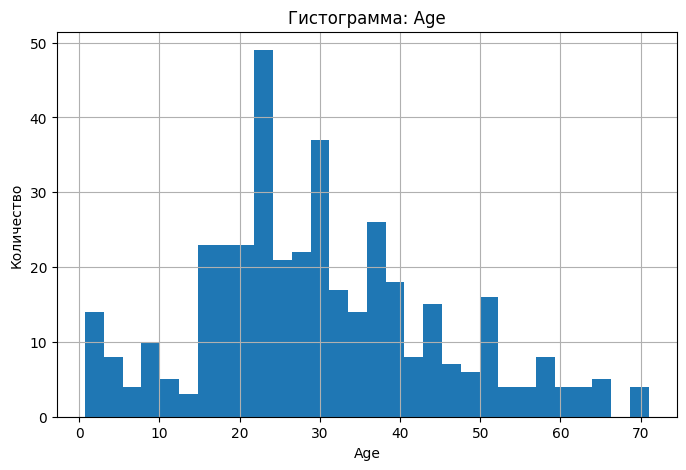

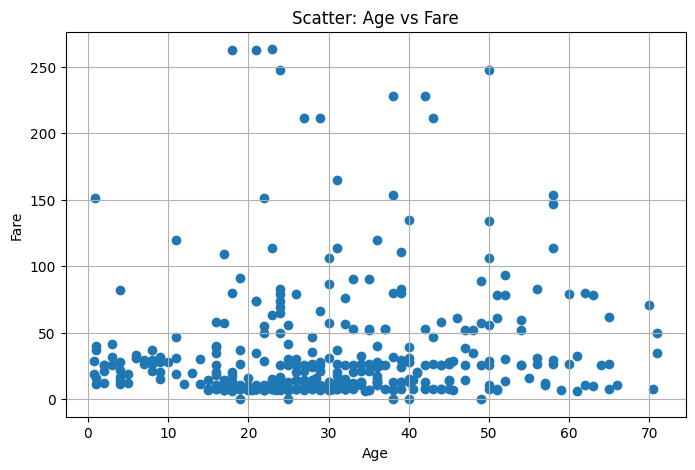

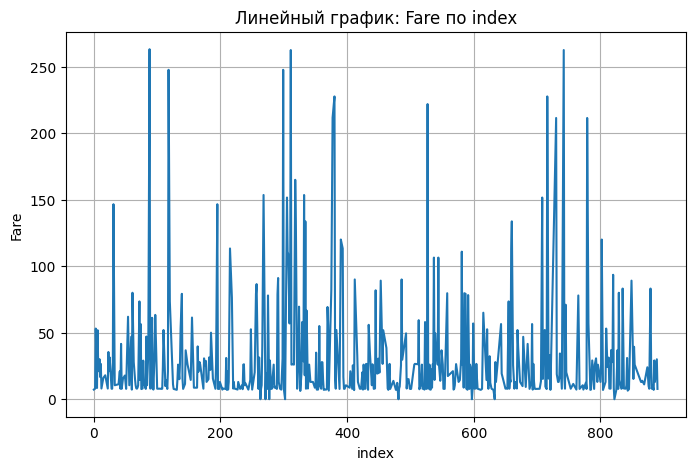


Построены визуализации: ['histogram_Age', 'scatter_Age_Fare', 'lineplot_index_Fare']

Обучение модели
Данные разделены: 668 для обучения, 223 для теста.

Обучаем модель RandomForestClassifier...
Модель успешно обучена.

Точность (Accuracy) на тестовых данных: 0.7937

Отчет о классификации:
              precision    recall  f1-score   support

           0       0.79      0.91      0.84       137
           1       0.80      0.62      0.70        86

    accuracy                           0.79       223
   macro avg       0.80      0.76      0.77       223
weighted avg       0.79      0.79      0.79       223


Матрица ошибок (Confusion Matrix):


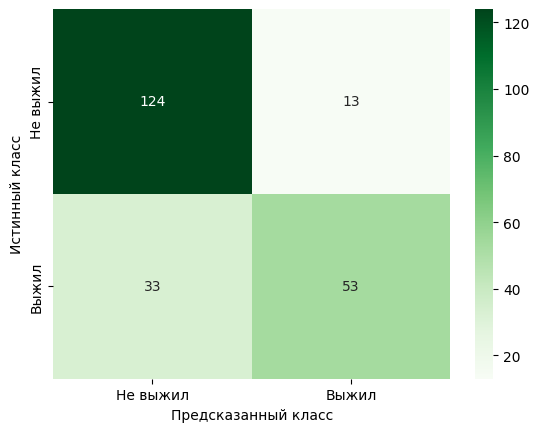

In [88]:
# Устанавливаем kagglehub для скачивания датасетов
!pip install kagglehub --quiet

import os
import kagglehub
import pandas as pd
# import importlib
# import visualization
# %writefile не меняет уже загруженные классы в памяти, поэтому старый метод всё ещё используется.
# importlib.reload(visualization)

from data_loader import DataLoader
from data_processing import DataProcessing
from visualization import Visualization
from model_training import train_and_evaluate


# Скачивание датасета
print("Скачиваем датасет Titanic...")
dataset_path = kagglehub.dataset_download("emrullahdemirhan/titaniccsv")

print(f"\nДатасет успешно скачан в папку: {dataset_path}")
print("Содержимое папки:")
for item in os.listdir(dataset_path):
    print("   -", item)

CSV_PATH = os.path.join(dataset_path, 'titanic.csv')

if not os.path.exists(CSV_PATH):
    raise FileNotFoundError(f"Файл titanic.csv не найден по пути: {CSV_PATH}")

print(f"\nПуть к CSV файлу: {CSV_PATH}")

loader = DataLoader()

print("\nЗагружаем данные в DataFrame...")
df = loader.load_from_csv(CSV_PATH)

print("\nДанные успешно загружены!")
print("Форма датасета:", df.shape)
display(df.head())

processor = DataProcessing()

# Подсчет пропусков
print("\nКоличество пропусков в каждом столбце:")
missing_counts = processor.count_missing(df)
print(missing_counts)

# Отчет о пропусках (используем реальные пропуски из CSV, если они есть)
try:
    print("\nОтчёт о пропущенных значениях:")
    missing_report = processor.report_missing(df)
    display(missing_report)
except Exception as e:
    print('Ошибка при формировании отчёта по пропускам:', e)

# Заполнить пропуски (пример: median) — опционально, можно изменить метод
try:
    print('\nЗаполняем пропуски методом median (если необходимо)...')
    df_filled = processor.fill_missing(df, method='median')
    print('Заполнение выполнено. Проверка пропусков после заполнения:')
    display(processor.report_missing(df_filled))
except Exception as e:
    print('Ошибка при заполнении пропусков:', e)

# Сохранение отчёта по пропускам
try:
    missing_report = processor.report_missing(df)
    missing_report.to_csv('missing_report_titanic_csv.csv')
    print('\nОтчёт сохранён в missing_report_titanic_csv.csv')
except Exception as e:
    print('Ошибка при сохранении отчёта:', e)

viz = Visualization()

# Визуализации (если столбцы есть)
try:
    if 'Age' in df.columns:
        viz.add_histogram(df, 'Age', sample_size=500)
    if 'Age' in df.columns and 'Fare' in df.columns:
        viz.add_scatter(df, 'Age', 'Fare', sample_size=500)
    # Линейный график по индексу и fare — демонстрационный
    viz.add_lineplot(df.reset_index(), 'index', 'Fare', sample_size=500)
    print('\nПостроены визуализации:', viz.plots)
except Exception as e:
    print('Ошибка при визуализации:', e)

# Обучение модели
print("\nОбучение модели")
model = train_and_evaluate(df, target_column='Survived')
